# Bayesian Blocks for Broad Excesses (formal)

The goal of the Bayesian Blocks (BB) binning algorithm (http://arxiv.org/abs/1207.5578) is to choose optimal bin edges for a given histogram.  The optimality criterion is expressed by choosing bin edges such that the content within the bin edges is consistent with a uniform distribution, and thus any fluctuation in data values within two given bin edges is solely statistical in nature.  This binning method was initially developed for the astronomy community, in which signals appear as a uniform distribution on top of a noisy, constant background.  If the signal is statistically significant with respect to the background, then it should fall into its own bin in order to maximize a fitness metric, which is a function of the data and the binning.


## A Black Hole Simulation

We have simulated data, and a functional form used to describe that data.

First, we will set up the necessary imports and function definitions:

In [1]:
from __future__ import division
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
from bb.tools.bb_plotter import make_fit_plot, make_bb_plot, make_bb_plot_v2, make_hist_ratio_blackhole2
import bb.paper.bh_comp as bh_tools
from lmfit import Parameters
from nllfit import NLLFitter, Model
from tqdm import tqdm_notebook
from scipy.stats import norm
from collections import defaultdict
import pandas as pd
from histogram_plus import hist

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

Welcome to JupyROOT 6.10/04


We will now load the Monte Carlo data, and specify the background and signal ranges.  We want the range of the BG to be 2800 to 13000 GeV.

In [2]:
bb_dir  = os.path.join(os.path.dirname(bh_tools.__file__), '../..')
df_data_mul2 = pd.read_pickle(bb_dir+'/files/BH/BH_test_data.p')
data_bg_mul2 = df_data_mul2[df_data_mul2.ST_mul2_BB>=2800].ST_mul2_BB.values

df_data_mul8 = pd.read_pickle(bb_dir+'/files/BH/BH_paper_data.p')
data_bg_mul8 = df_data_mul8[df_data_mul8.ST_mul8_BB>=2800].ST_mul8_BB.values

xlimits = (2800, 13000)
x       = np.linspace(xlimits[0], xlimits[1], 10000)
nbins   = 102 # for 10 GeV histogram binning
binning = (xlimits[1]-xlimits[0])/nbins

The background function will be fit with a 3rd order Legendre polynomial, and the signal will be fit with a Gaussian distribution.  These functional forms will be used to generate background and signal MC, which will then be evaluated with the BB algorithm.  This is done to allow for an easy comparison of statistical significance between the BB and unbinned fit methods without the introduction of additional uncertainty regarding the true underlying pdfs.

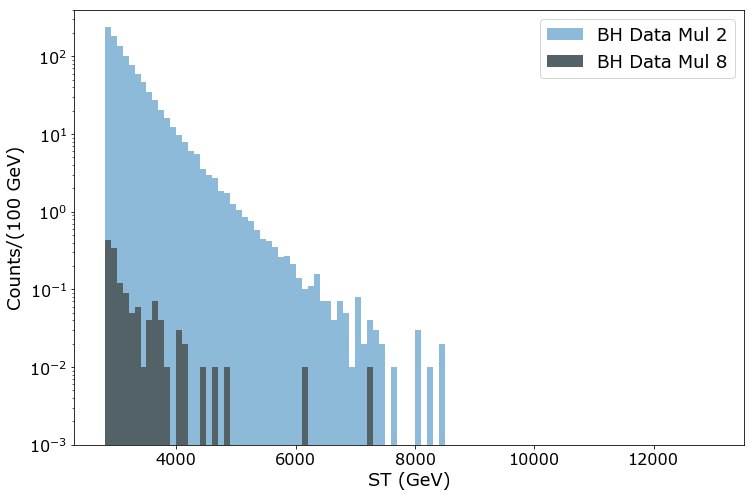

In [3]:
#ax = plt.subplot()
hist(data_bg_mul2, bins = 102, histtype='stepfilled', alpha=0.5, label='BH Data Mul 2', range=xlimits, log=True, scale='binwidth')
hist(data_bg_mul8, bins = 102, histtype='stepfilled', alpha=1, label='BH Data Mul 8', range=xlimits, log=True, color='xkcd:gunmetal', scale='binwidth')
plt.legend()
plt.ylabel('Counts/(100 GeV)')
plt.xlabel('ST (GeV)')
#ax.set_yscale("log", nonposy='clip')
#ax.set_ylim(ymin=0.1)

Fit finished with status: 0

[[Variables]]
    alpha:   13.1617081 +/- 13.16170 (100.00%) (init=-18.0808)
    beta:   -6.58482915 +/--6.584829 (100.00%) (init=-0.0821174)
    gamma:   1.77075339 +/- 1.770753 (100.00%) (init= 0.806289)

[[Correlation matrix]]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]] 



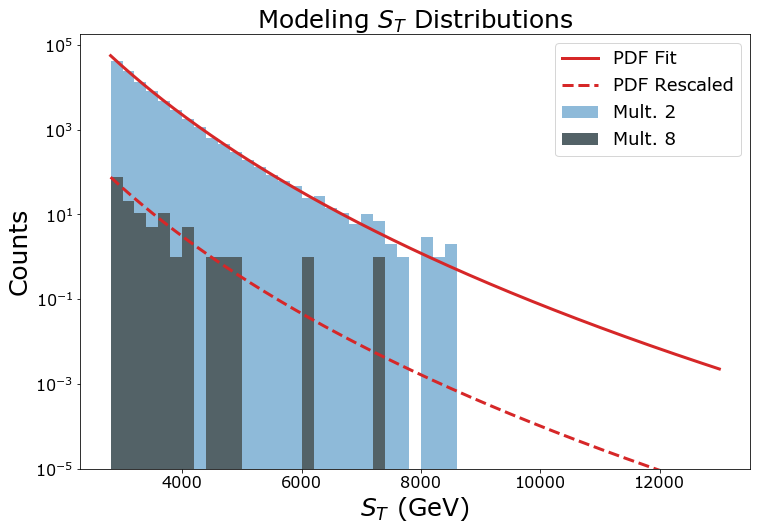

In [4]:
bg_params = Parameters()
bg_params.add_many(
    ('alpha', -1.80808e+01, True, 1e-20, 20, None, None),
    ('beta', -8.21174e-02, True, -10, -1e-20, None, None),
    ('gamma', 8.06289e-01, True, 1e-20, 10, None, None)
)

bg_model = Model(bh_tools.bg_pdf, bg_params)
bg_fitter = NLLFitter(bg_model)
bg_result = bg_fitter.fit(data_bg_mul2, calculate_corr=False)

#bg_result = bg_fitter.fit([-1.80808e+01, 8.06289e-01])

textstr = (r'$\alpha={0:.2f}$''\n'r'$\beta={1:.2f}$''\n'r'$\gamma={2:.2f}$').format(*bg_result.x)
#textstr = ('$a_1={0:.2f}$\n$a_2={1:.2f}$').format(*bg_result.x)
ax = make_fit_plot(data_bg_mul2, 51, (2800, 13000), functools.partial(bh_tools.bg_pdf, a=bg_result.x),
        'Fit to ST Distributions', textstr = None, hist_label='Mult. 2', pdf_label='PDF Fit')
ax = make_fit_plot(data_bg_mul8, 51, (2800, 13000), functools.partial(bh_tools.bg_pdf, a=bg_result.x),
        'Fit to ST Distributions', textstr = None, ax=ax, hist_label='Mult. 8', pdf_label='PDF Rescaled',
                  xlabel='ST (GeV)', color='xkcd:gunmetal', alpha=1, pdf_line='--')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)
#plt.ylabel(r'$\mathrm{\frac{Counts}{200\ GeV}}$', fontsize=30)
plt.ylabel('Counts', fontsize=25)
plt.xlabel('$S_T$ (GeV)', fontsize=25)
plt.title(r'Modeling $S_T$ Distributions',fontsize=25)
plt.savefig(bb_dir+'/plots/bh_example/bh_init_fit.pdf',bbox_inches='tight')


## Generating MC from PDFs

We will use the functional forms defined above to create MC toys using the ROOT pdf sampling methods.  We are going to generate the same number of background and signal events as defined above, and then combine them together into a single dataset.  We can then fit that dataset with the combined background and signal pdfs, and extract a p-value and Gaussian Z-score based on the profile likelihood ratio.

In [5]:
from ROOT import gRandom
from ROOT import TF1

gRandom.SetSeed(111)

# Set up bg sampling
bg_pdf_ROOT = functools.partial(bh_tools.bg_pdf, doROOT=True)
tf1_bg_pdf = TF1("tf1_bg_pdf", bg_pdf_ROOT, 2800, 13000, 3)
tf1_bg_pdf.SetParameters(*bg_result.x)
mc_bg = [tf1_bg_pdf.GetRandom() for i in range(len(data_bg_mul8))]

# Set up signal sampling
sig_pdf_ROOT = functools.partial(bh_tools.sig_pdf, doROOT=True)
tf1_sig_pdf = TF1("tf1_sig_pdf", sig_pdf_ROOT, 2800, 13000, 2)
tf1_sig_pdf.SetParameters(6000, 1200)
mc_sig_more = [tf1_sig_pdf.GetRandom() for i in range(len(data_bg_mul8))]
mc_sig_less = [tf1_sig_pdf.GetRandom() for i in range(8)]

print('number of bg events:',len(mc_bg))
print('number of sig events:', len(mc_sig_more))

mc_bg_sig = mc_bg+mc_sig_less

number of bg events: 136
number of sig events: 136


TypeError: list indices must be integers or slices, not tuple

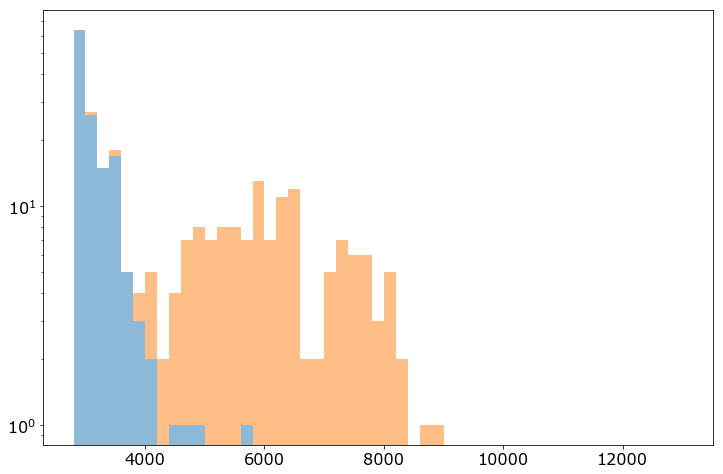

In [6]:
ax = plt.subplot()
hist([mc_bg, mc_sig_more], bins = 51, range=xlimits, stacked=True,
         histtype='stepfilled', label=['QCD BG', 'BH Signal'], log=True)
plt.legend()
plt.ylabel('Counts/(100 GeV)')
plt.xlabel('ST (GeV)')
#ax.set_yscale("log", nonposy='clip')
#ax.set_ylim(ymin=0.00001)

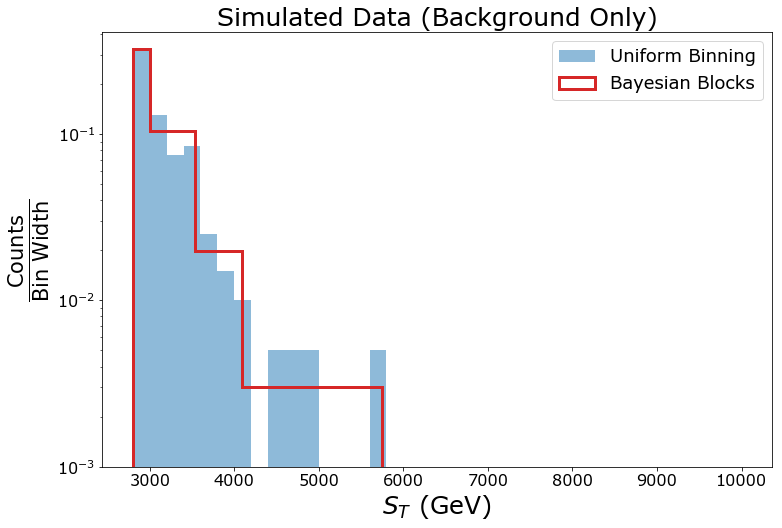

In [9]:
import warnings
warnings.filterwarnings("ignore")

hist_bg_200 = hist(mc_bg, bins=36, range=(2800, 10000), scale='binwidth', label='Uniform Binning')
hist_bg_bb = hist(mc_bg, bins='blocks', p0=0.02, range=(2800, 10000), color='C3', scale='binwidth', alpha=1, label='Bayesian Blocks', histtype='step', linewidth=3)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.001)
plt.legend()
plt.ylabel(r'$\mathrm{\frac{Counts}{Bin\ Width}}$', fontsize=30)
plt.xlabel('$S_T$ (GeV)', fontsize=25)
plt.title('Simulated Data (Background Only)',fontsize=25)
plt.savefig(bb_dir+'/plots/bh_example/bh_bg_hist_bb.pdf',bbox_inches='tight')

bc_bg = hist_bg_bb[0]
be_bg = hist_bg_bb[1]
be_bg[-1] = be_bg[-1]+0.1
be_bg=np.append(be_bg, [13000])
be_bg[0] = 2800


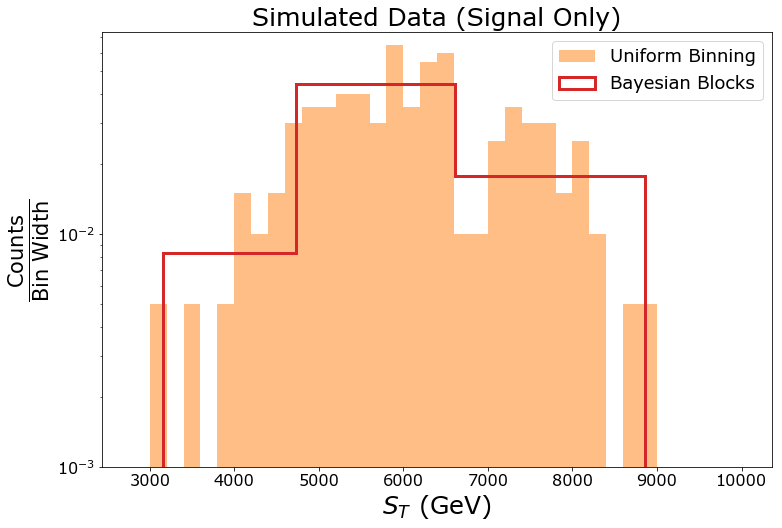

In [17]:
import warnings
warnings.filterwarnings("ignore")

hist_sig_200 = hist(mc_sig_more, bins=36, range=(2800, 10000), scale='binwidth', label='Uniform Binning', color='C1')
hist_sig_bb = hist(mc_sig_more, bins='blocks', p0=0.02, range=(2800, 10000), color='C3', scale='binwidth', alpha=1, label='Bayesian Blocks', histtype='step', linewidth=3)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.001)
plt.legend()
plt.ylabel(r'$\mathrm{\frac{Counts}{Bin\ Width}}$', fontsize=30)
plt.xlabel('$S_T$ (GeV)', fontsize=25)
plt.title('Simulated Data (Signal Only)',fontsize=25)
plt.savefig(bb_dir+'/plots/bh_example/bh_sig_hist_bb.pdf',bbox_inches='tight')

bc_sig = hist_sig_bb[0]
be_sig = hist_sig_bb[1]
be_sig[-1] = be_sig[-1]+0.1
be_sig=np.append(be_sig, [13000])
be_sig[0] = 2800

In [11]:
be_hybrid = np.sort(np.unique(np.concatenate([be_sig, be_bg])))


In [12]:
mc_bg_sig_more = np.concatenate([mc_bg, mc_sig_more])

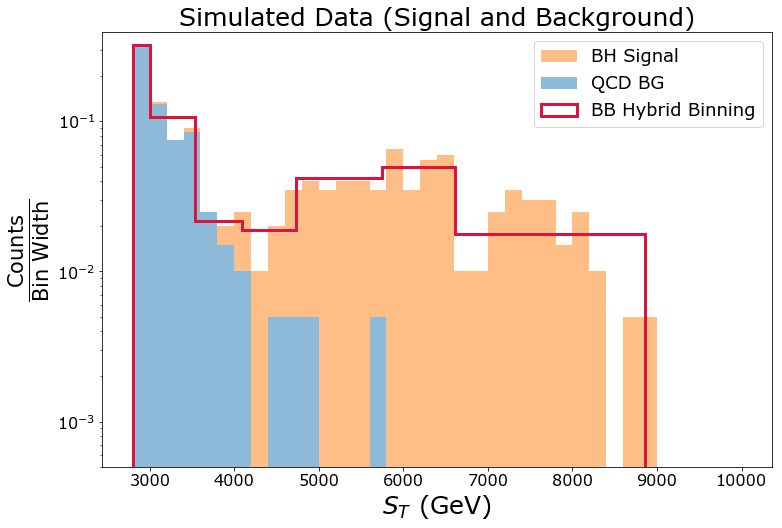

In [18]:
_  = hist([mc_bg, mc_sig_more], bins = 36, range=(2800, 10000), stacked=True,
         histtype='stepfilled', label=['QCD BG', 'BH Signal'], scale='binwidth', log=True)

_ = hist(mc_bg_sig_more, bins = be_hybrid[:-1], range=(2800, 10000),
         color='crimson', histtype='step', label=['BB Hybrid Binning'], scale='binwidth', linewidth=3, log=True)

plt.ylabel(r'$\mathrm{\frac{Counts}{Bin\ Width}}$', fontsize=30)
plt.xlabel('$S_T$ (GeV)', fontsize=25)
plt.title('Simulated Data (Signal and Background)',fontsize=25)
plt.savefig(bb_dir+'/plots/bh_example/bh_hybrid_hist_bb.pdf',bbox_inches='tight')
plt.legend()


#plt.savefig('figures/bh_hybrid_hist_bb.pdf')

In [14]:
mc_bg_est = [tf1_bg_pdf.GetRandom() for i in range(1000000)]
mc_sig_est = [tf1_sig_pdf.GetRandom() for i in range(1000000)]
be_100GeV = np.linspace(2800, 13000, 52)

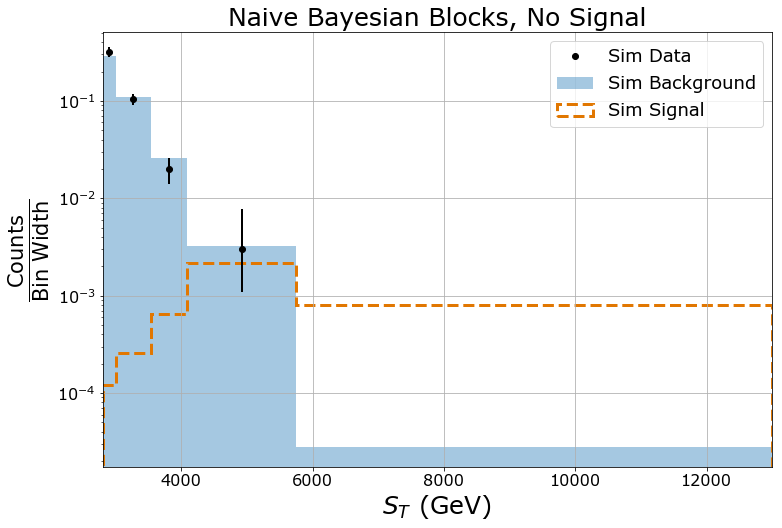

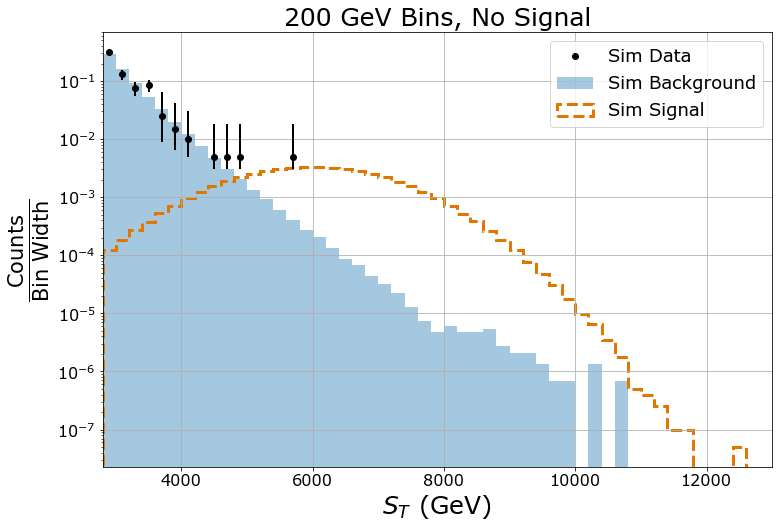

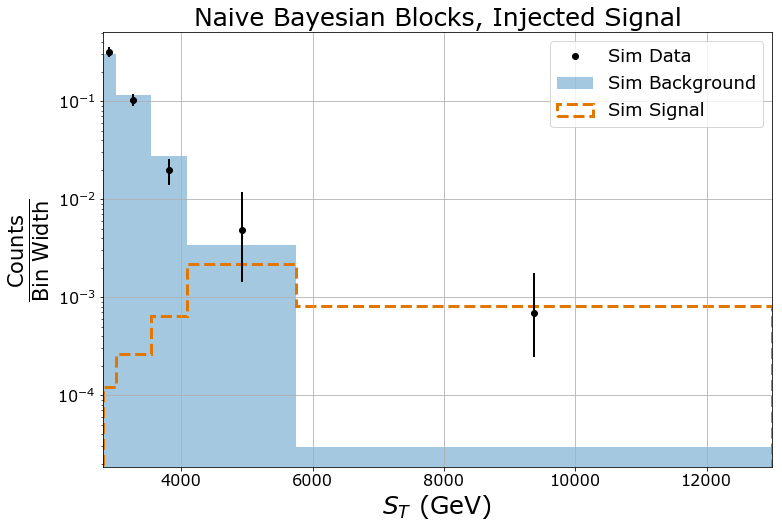

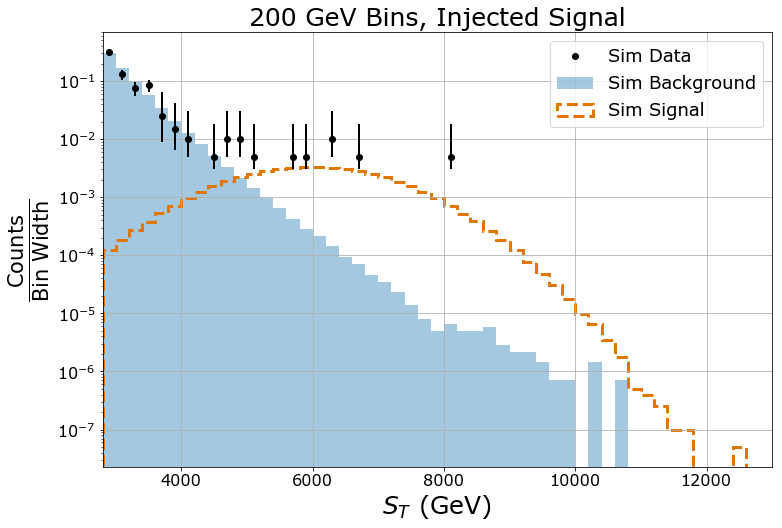

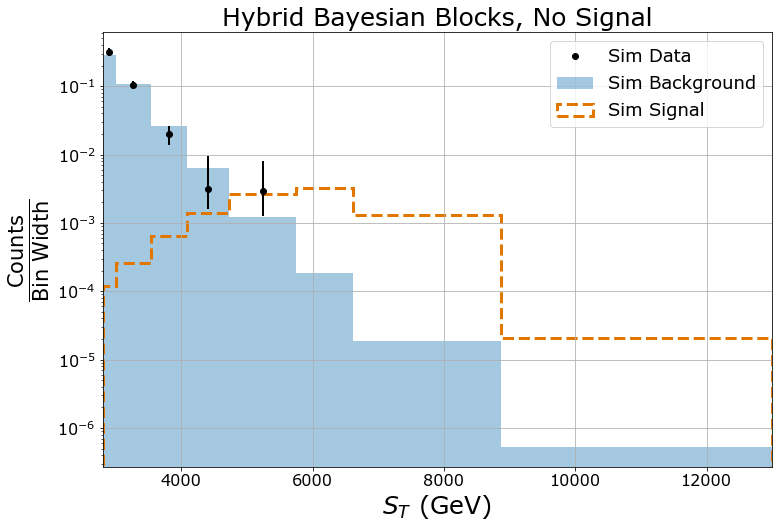

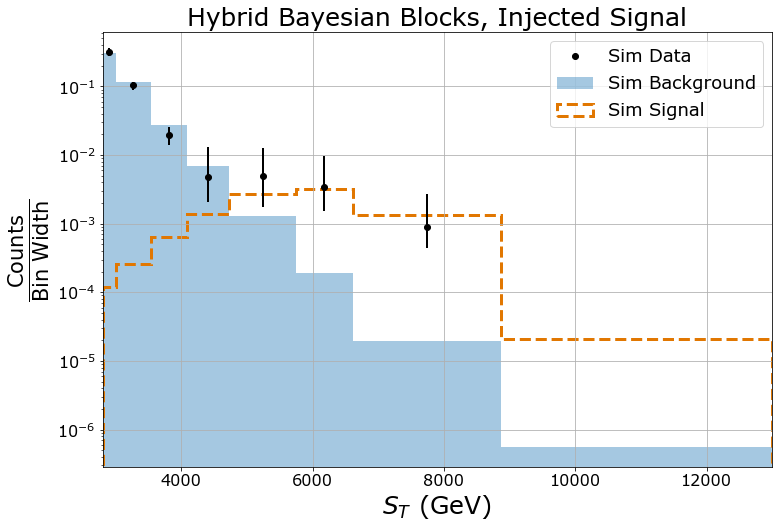

In [16]:
bh_tools.bh_ratio_plots(mc_bg, mc_bg_est, be_bg, title = 'Naive Bayesian Blocks, No Signal',
                       save_name = 'bh_bb_vis_no_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg, mc_bg_est, be_100GeV, title = '200 GeV Bins, No Signal',
                       save_name = 'bh_b100_vis_no_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg_sig, mc_bg_est, be_bg, title = 'Naive Bayesian Blocks, Injected Signal',
                       save_name = 'bh_bb_vis_inj_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg_sig, mc_bg_est, be_100GeV, title = '200 GeV Bins, Injected Signal',
                       save_name = 'bh_b100_vis_inj_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg, mc_bg_est, be_hybrid, title = 'Hybrid Bayesian Blocks, No Signal',
                       save_name = 'bh_bb_hybrid_vis_no_sig', signal_mc = mc_sig_est)
bh_tools.bh_ratio_plots(mc_bg_sig, mc_bg_est, be_hybrid, title = 'Hybrid Bayesian Blocks, Injected Signal',
                       save_name = 'bh_bb_hybrid_vis_inj_sig', signal_mc = mc_sig_est)

Now we will fit these distributions with the functional forms used to generate them.  We will fit with a background-only pdf and a background+signal pdf.  The ratio of the likelihood produced by these two methods will be used to calculate the significance.

In [ ]:
mc_bg_only_fitter = ff.NLLFitter(bg_model, np.asarray(mc_bg_sig))
mc_bg_only_result = mc_bg_only_fitter.fit(bg_result.x)

textstr = (r'$\alpha={0:.2f}$''\n'r'$\beta={1:.2f}$''\n'r'$\gamma={2:.2f}$').format(*mc_bg_only_result.x)
ax = make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(bh_tools.bg_pdf, a=mc_bg_only_result.x),
    'BG only model to Signal+BG Toy', textstr = textstr)
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

In [ ]:
bg_sig_model = ff.Model(bh_tools.bg_sig_pdf, ['C', 'mu', 'sigma', 'alpha', 'beta', 'gamma'])
bg_sig_model.set_bounds([(0, 1), (5000, 5000), (1000, 1000), (mc_bg_only_result.x[0], mc_bg_only_result.x[0]),
                         (mc_bg_only_result.x[1], mc_bg_only_result.x[1]), (mc_bg_only_result.x[2],mc_bg_only_result.x[2])])
mc_bg_sig_fitter = ff.NLLFitter(bg_sig_model, np.asarray(mc_bg_sig))
mc_bg_sig_result = mc_bg_sig_fitter.fit([0.01, 5000, 1000, mc_bg_only_result.x[0], mc_bg_only_result.x[1], mc_bg_only_result.x[2]])

textstr = ('$C={0:.2f}$\n$\mu={1:.2f}$\n$\sigma={2:.2f}$\n'
          '$a_1={3:.2f}$\n$a_2={4:.2f}$\n$a_3={5:.2f}$').format(*mc_bg_sig_result.x)
ax = make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(bh_tools.bg_sig_pdf, a=mc_bg_sig_result.x),
    'Signal+BG model to Signal+BG Toy', extra_pdf_tuple=(functools.partial(bh_tools.bg_sig_pdf,
    a=np.concatenate([[0], mc_bg_sig_result.x[1:]])), 1-mc_bg_sig_result.x[0], 'bg pdf'), textstr = textstr)
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

scan_vals = np.arange(0,0.1,0.001)
nll_vals = []
for i in tqdm_notebook(range(len(scan_vals))):
    test_model = ff.Model(bh_tools.bg_sig_pdf, ['C', 'mu', 'sigma', 'alpha', 'beta', 'gamma'])
    test_model.set_bounds([(scan_vals[i]-0.0001, scan_vals[i]+0.0001), (5000, 5000), (1000, 1000), (mc_bg_only_result.x[0], mc_bg_only_result.x[0]),
                           (mc_bg_only_result.x[1], mc_bg_only_result.x[1]), (mc_bg_only_result.x[2],mc_bg_only_result.x[2])])
    test_fitter = ff.NLLFitter(test_model, np.asarray(mc_bg_sig), verbose=False)
    test_result = test_fitter.fit([scan_vals[i], 5000, 1000, mc_bg_only_result.x[0], mc_bg_only_result.x[1], mc_bg_only_result.x[2]])
    nll_vals.append(test_result.fun)
    


In [ ]:
print nll_vals

Now that we have fit the distribution with both a bg-only and a bg+signal pdf, we can compare the two likelihoods in the following way:
$$\lambda(\mu)=\frac{L(\mu,\hat{\hat{\boldsymbol{\theta}}})}{L(\hat{\mu},\hat{\boldsymbol{\theta}})}$$
where $\mu=0$ (representing the background-only hypothesis), and $\hat{\mu}$ is a free parameter, determined by the fitting procedure.  We can then use then construct the test statistic $q_0$ for discovering a new signal:
$$q_{\mu} = \left\{ \begin{array}{ll} -2\ln\lambda(\mu) & \quad \hat{\mu} \leq \mu, \\ 0 & \quad \hat{\mu} > \mu \end{array} \right.$$
Assuming the Wald approximation holds (https://arxiv.org/abs/1007.1727), the pdf of $q_0$ for a given $\mu$ can be represented by a $\frac{1}{2}\chi^2$ distribution of 1 degree of freedom, and the CDF of that distribution is:
$$F(q_{\mu}|\mu)=\Phi(\sqrt{q_\mu})$$
The p-value is:
$$p_\mu = 1-F(q_{\mu}|\mu) = 1-\Phi(\sqrt{q_\mu})$$

A 95% UL can be found as the value of $\mu$ for which $p_\mu = \alpha$, and $\alpha = 0.05$.

In [ ]:
from IPython.display import HTML
nll_bg  = mc_bg_only_result.fun
nll_sig = mc_bg_sig_result.fun
print mc_bg_sig_result.x
p_vals = []
qus = []
for val in nll_vals:
    qu = 2*max(val-nll_sig, 0)
    pval = 1-norm.cdf(qu)
    #print pval
    p_vals.append(pval)
    qus.append(qu)
#q0= 2*max(nll_bg-nll_sig,0)
#HTML('<h3><b>Significance of peak from nll fit: {0:.3f} sigma</b></h3>'.format(np.sqrt(q0)))
for i,p in enumerate(p_vals):
    if np.isclose(p, 0.05, 0.002, 0.002):
        print i, p

fig, ax1 = plt.subplots()
ax1.plot(scan_vals, qus, 'b')
ax1.set_xlabel('signal strengths ($\mu$)')
ax1.set_ylabel('$q_\mu$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(scan_vals, p_vals, 'r')
ax2.set_ylabel('p-values', color='r')
ax2.tick_params('y', colors='r')
ax2.plot(scan_vals[48], p_vals[48], 'k*')
ax2.annotate('95% CL', xy=(0.048, 0.05), xytext=(0.06, 0.15),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title('Test-statistic and p-values for signal Mass=5000, Width=1000 GeV')




## Using Bayesian Blocks Binning to Produce Confidence Intervals

We will repeat the above procedure for many toys, and produce the typical banana plot that is common for LHC limit setting across multiple signal masses.

* Generate initial fit to bg simulation.
* Produce toys from that fit.
* Determine mass points.
* Fit each toy with each mass point, allowing signal strength to fluctuate.
* Calculate the 95% CL signal strength for each toy, for each mass point, by scanning the signal strength.
* Make banana plot.

**Bonus**
* Instead of using $q_\mu$, use an ensample of best fits to toys to determine 95%CL on signal strength.


## Running Many Toys

In the following comparison, we will repeat the previous studies for many toys, then compare the average significance for both the nll fit and bayesian block methods. Note: cut and count is integral of all events after an ST value of X, where is X is determined as the ST value that gives the best expected limit.

In [36]:
%run bh_comp.py

Fit finished with status: 0

[[Variables]]
    alpha:   13.1617081 +/- 13.16170 (100.00%) (init=-18.0808)
    beta:   -6.58482915 +/--6.584829 (100.00%) (init=-0.0821174)
    gamma:   1.77075339 +/- 1.770753 (100.00%) (init= 0.806289)

[[Correlation matrix]]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]] 



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

2851


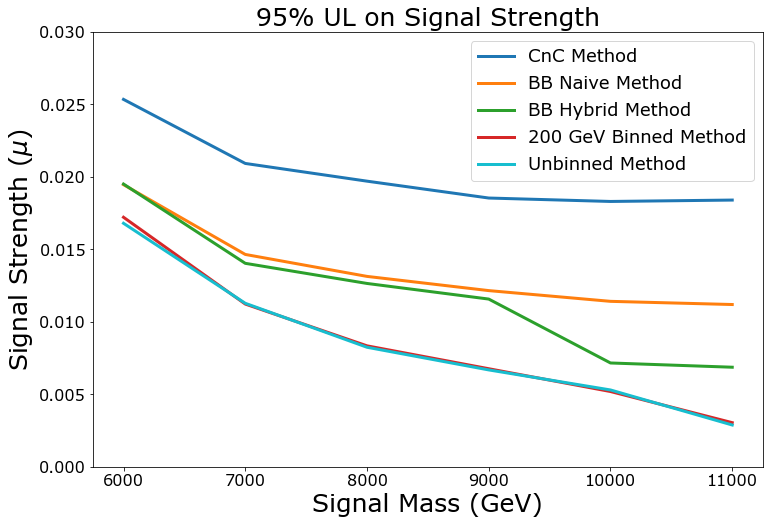

In [37]:
masses = [6000, 7000, 8000, 9000, 10000, 11000]
#plt.plot(masses, [mean(i) for i in unbinned_A], label='Unbinned Method', linewidth=2)
index_95 = int(len(unbinned_A_mle[0])*0.95)+1
print(index_95)
plt.plot(masses, [sorted(i)[index_95] for i in cnc_A_mle], label='CnC Method', linewidth=3)
plt.plot(masses, [sorted(i)[index_95] for i in binned_A_mle], label='BB Naive Method', linewidth=3)
plt.plot(masses, [sorted(i)[index_95] for i in binned_A_hybrid_mle], label='BB Hybrid Method', linewidth=3)
plt.plot(masses, [sorted(i)[index_95] for i in binned_A_200_mle], label='200 GeV Binned Method', linewidth=3)
plt.plot(masses, [sorted(i)[index_95] for i in unbinned_A_mle], label='Unbinned Method', linewidth=3, color='C9')

#plt.plot(masses, [mean(i) for i in binned_A_200], label='200 GeV Binned Method')
#plt.plot(masses, [mean(i) for i in binned_A_400], label='400 GeV Binned Method')
#plt.plot(masses, [mean(i) for i in binned_A_1000], label='1000 GeV Binned Method')
#plt.plot(masses, [mean(i) for i in binned_A_2000], label='5 Uniform bins', linewidth=2)

plt.title('95% UL on Signal Strength', fontsize=25)
plt.ylabel('Signal Strength ($\mu$)', fontsize=25)
plt.xlabel('Signal Mass (GeV)', fontsize=25)
plt.legend()
#plt.yscale('log')
plt.ylim(0, 0.03)
#plt.savefig('figures/bh_limits.pdf')
plt.savefig(bb_dir+'/plots/bh_example/bh_limits.pdf',bbox_inches='tight')


In [ ]:
be_hybrid, be_bg, be_sig, be_2000GeV

In [ ]:
plt.hist(cnc_A_mle[0], bins=100)
plt.yscale('log')

In [ ]:
plt.hist(unbinned_A_mle[0], bins=100)
plt.yscale('log')

In [ ]:
plt.hist(unbinned_A[1], bins=50, alpha=0.5)
plt.xlabel('Best Fit Val for $A$')
plt.ylabel('Entries')
#plt.hist(binned_A_100[2], bins=50, alpha=0.5)
#plt.hist(unbinned_A[0], bins=50, alpha=0.5)
plt.title('Unbinned Fits')


In [ ]:
plt.hist(binned_A[3], bins=50, alpha=0.5)
plt.xlabel('Best Fit Val for $A$')
plt.ylabel('Entries')
#plt.hist(binned_A_100[2], bins=50, alpha=0.5)
#plt.hist(unbinned_A[0], bins=50, alpha=0.5)
plt.title('Binned Fits')

In [ ]:
plt.plot(unbinned_A[3], unbinned_A_mle[3], 'bo')
plt.xlabel('A_95')
plt.ylabel('A_mle')
plt.title('Unbinned Fits, A_95 vs A_mle')

In [ ]:
plt.plot(binned_A[3], binned_A_mle[3], 'bo')
plt.xlabel('A_95')
plt.ylabel('A_mle')
plt.title('Binned Fits, A_95 vs A_mle')